# The numpy.random module

The "import" statement brings in other *namespaces* where functions and variables may live. 
import *module* as *name* allows for not retyping the whole name of a module if it will be used a lot.
The primary module for numerical computing we use is called __numpy__, and contains functions for mathematical work and random number generation.

In [42]:
import numpy as np

To call a function that requires no arguments, we simply append () to its name. The module _np.random_ contains "random" number generation, with the function _random_ that generates a single continuous uniform `[0,1]`.

In [51]:
for i in range(3):
    print(np.random.random())

0.3358025104298902
0.8238553298072178
0.865148249705259


The numbers generated by random() are not truly random -- they are called __psuedorandom__ numbers. They are given by a deterministic stream of numbers starting at a _seed_ value:

In [55]:
np.random.seed(126)
for i in range(3):
    print(np.random.random())

0.10517212721767522
0.12814407203400036
0.08740630845952124


In [27]:
np.random.seed(126)
for i in range(3):
    print(np.random.random())

0.10517212721767522
0.12814407203400036
0.08740630845952124


Using seeds is extremely important since we want our results to be replicable, both by ourselves and by others. "True" sources of randomness, e.g. what you might get from atmospheric noise from https://www.random.org/, are not useful for us and should not typically be used in economics.
__Always__ set a seed at the beginning of an analysis.

# Linear congruential generators 

A pseudo-random number drawn from $X$ is intuitively defined by two properties:
1. The empirical distribution of the pseduo-random numbers should match that of X as closely as possible as the number of draws gets large.
2. Knowledge of previous pseudo-random draws from X gives no information about the next draw of X.

Amazingly, there are very simple deterministic procedures that can satisfy 1. and 2. fairly well, and refinements of these methods can be indistinguishable from a true string of random numbers with our current technology.

The easiest method to explain to generate $Uniform[0,1]$ variates -- which we will then use to draw from arbitrary distributions -- is a class of functions called _Linear Congruential Generators_. These generate $X$ using the recurrence relation

$X_{n} = (a X_{n-1} + c) \mod m$

for some non-negative integer parameters $a$ (_multiplier_), $c$ (_increment_), $m$ (_modulus_), and $X_0$ (_seed_).

For an obvious non-random example, consider the case $m$ prime, $c=0$: 

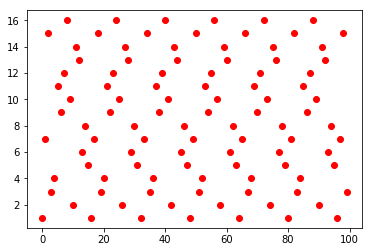

In [28]:
import matplotlib.pyplot as plt
plt.figure()
x = 1
for i in range(100):
    plt.plot(i, x, 'ro')
    x = (7 * x + 0) % 17
plt.show()

By choosing particular values of the seed, multiplier, and increment, you can find particularly good properties of the generated output, with millions of draws before a cycle. There are also bad values of these parameters, but any programming language implementation should be fine for our purposes.

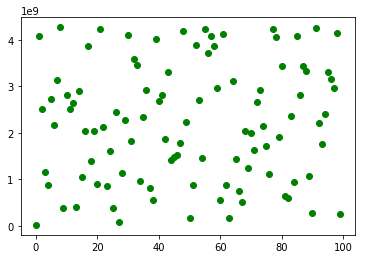

In [29]:
plt.figure()
x = 2**23 + 3**15
for i in range(100):
    plt.plot(i, x, 'go')
    x = (1103515245 * x + 12345) % 2**32
plt.show()

Generate 1000 values from this LCG and draw the histogram. Not bad.

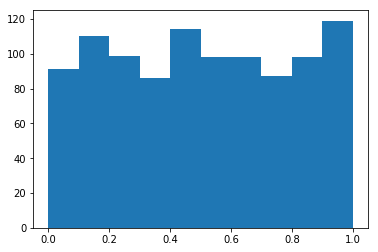

In [30]:
x = np.zeros(1000, dtype=np.intp)
x[0] = 2**23 + 3**15
for i in range(1,1000):
    x[i] = (1103515245 * x[i-1] + 12345) % 2**32
plt.figure() 
plt.hist(x/2**32) #rescale between 0,1
plt.show()

Does the approximation to the Uniform improve after a million draws?

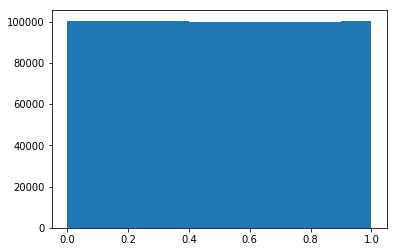

In [31]:
x = np.zeros(1000000, dtype=np.intp)
x[0] = 2**23 + 3**15
for i in range(1,1000000):
    x[i] = (1103515245 * x[i-1] + 12345) % 2**32
plt.figure()
plt.hist(x/2**32)
plt.show()

And lastly, what is the correlation between each draw and the previous one?

In [32]:
print(np.corrcoef(x[:-1], x[1:])[1,0])

-0.000450580358106


In [33]:
def uniformrv(length, seed=2**23 + 3**15):
    x = np.zeros(length, dtype=np.float64)
    for i in range(length):
        x[i] = (1103515245 * x[i-1] + 12345) % 2**32
    return x/2**32

# Drawing from non-uniform random variables

The easiest way to sample from a random variable with known CDF $F(x)$ is what is known as Inverse Transform Sampling. (Easiest conceptually and easiest to program, but this is often computationally inefficient.) Inverse transform sampling uses the fact that for a random variable $X$ with CDF $F(x)$ and a $Uniform[0,1]$ rv $U$, 

$F^{-1}(U)\sim X$,

that is, $F^{-1}(U)$ has the same distribution as $X$.

It's easy to see this fact from our CDF transform method. 

If $\Pr(U\leq u) = u$ and $\Pr(X\leq x) = F(x)$, $\Pr(F^{-1}(U)\leq x) = \Pr(U\leq F(x)) = F(x)$ as desired.


### Exponential Distribution 

For example, we know the CDF of the Exponential($\lambda$) distribution is
$F(x) \equiv z = 1 - e^{-\lambda x}$, and we can invert this to find $F^{-1}(z) = -\frac{1}{\lambda} \log(1-z)$.

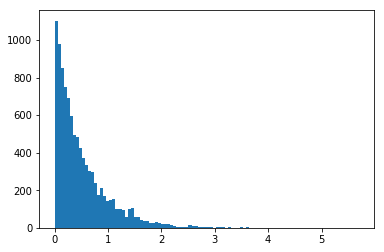

In [34]:
z = uniformrv(10000)
lam = 2.0
inversetransformsampled = -1/lam * np.log(1-z)

plt.figure()
plt.hist(inversetransformsampled, bins=100)
plt.show()

### Logistic Distribution

$F(x) \equiv z = \frac {1}{(1 + \exp(-x))} \rightarrow x = \log(\frac{z}{1-z})$

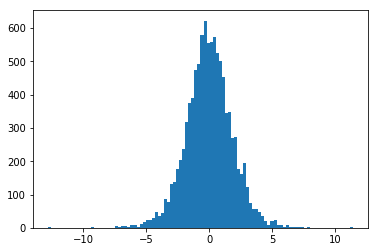

In [35]:
# same z (uniform draws) as above
inversetransformsampled = np.log(z/(1-z))

plt.figure()
plt.hist(inversetransformsampled, bins=100)
plt.show()

### Cauchy Distribution

$F(x) \equiv z = \frac{1}{2} + \arctan(x) \rightarrow x = \tan(\pi(z-\frac{1}{2}))$
As you can see, generating from the Cauchy using the inverse transform sampling method has some issues. The Cauchy can be written as the ratio of two standard normals, but still is difficult to work with.

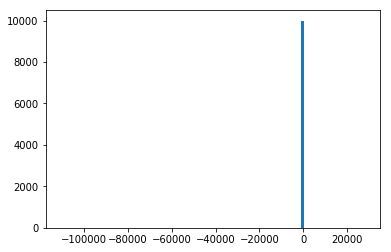

In [36]:
inversetransformsampled = np.tan(np.pi * (z-.5))
plt.figure()
plt.hist(inversetransformsampled, bins=100)
plt.show()

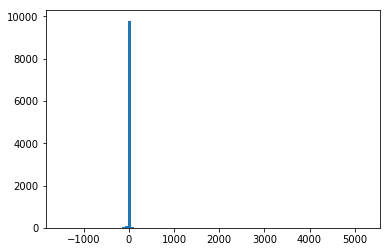

In [37]:
inversetransformsampled = np.random.normal(size=z.size)/np.random.normal(size=z.size)
plt.figure()
plt.hist(inversetransformsampled, bins=100)
plt.show()

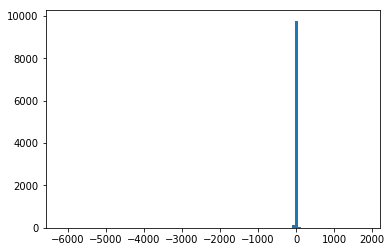

In [38]:
inversetransformsampled = np.random.standard_cauchy(size=z.size)
plt.figure()
plt.hist(inversetransformsampled, bins=100)
plt.show()

### Standard Normal

Unfortunately, since the standard normal has no closed-form CDF, the inverse transform sampling method requires numerical evaluation of $\Phi^{-1}(z)$, which is relatively computationally expensive. There are plenty of algorithms out there that use special transformations, e.g. https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform, and any programming language you use will have a good one.

Just to show we can use the inverse tranform sampling method in a pinch, the module scipy.stats has the inverse normal CDF in a function called "norm.ppf".

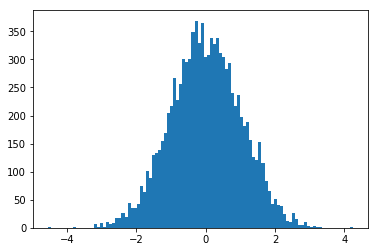

In [39]:
import scipy.stats
inversetransformsampled = scipy.stats.norm.ppf(z)
plt.figure()
plt.hist(inversetransformsampled, bins=100)
plt.show()

But as you can see, this method is signficantly slower (even with the uniforms already generated!) then simply using a built-in efficient random normal generator. If a library provides a dedicated random number generator for a distribution, it is almost always going to be signficantly faster than a manual implementation.

In [40]:
%timeit scipy.stats.norm.ppf(z)

1000 loops, best of 3: 677 µs per loop


In [41]:
%timeit (np.random.normal(size=z.size))

1000 loops, best of 3: 258 µs per loop
